In [11]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
from tensorflow import keras 
from keras.models import Sequential 
from keras.layers import Dense,GlobalAveragePooling2D
from keras.utils import to_categorical
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm 
from sklearn.model_selection import train_test_split 
from keras.applications import inception_resnet_v2
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import glob 
import cv2

#### Loading the dataset

In [12]:
import pathlib

dataset = pathlib.Path("lung_colon_image_set/lung_image_sets/")
images = list(dataset.glob('*/*.jpeg'))

In [13]:
lbt = dataset.glob('lung_n/*')
laca = dataset.glob('lung_aca/*')
lscc = dataset.glob('lung_scc/*')

lung_benign_tissue = list(lbt)
lung_adenocarcinoma = list(laca)
lung_squamous_cell_carcinoma = list(lscc)

In [14]:
label_dict = {
    'lung_benign_tissue' : 0,
    'lung_adenocarcinoma' : 1,
    'lung_squamous_cell_carcinoma' : 2,
}

image_dict = {
    'lung_benign_tissue' : lung_benign_tissue,
    'lung_adenocarcinoma' : lung_adenocarcinoma,
    'lung_squamous_cell_carcinoma' : lung_squamous_cell_carcinoma,
}

#### Preprocessing

In [15]:
x,y = [],[]

for name,images in tqdm(image_dict.items(), desc='Processing Images'):
    for img in tqdm(images, desc=f'Processing {name} Images', leave=False):
        i = cv2.imread(str(img))
        resized_image = cv2.resize(i,(200,200))
        resized_image = resized_image.astype(np.float16)/255.0
        resized_image = np.round(resized_image,4)
        x.append(resized_image)
        y.append(label_dict[name])

x = np.array(x)
y = np.array(y)

Processing Images: 100%|██████████| 3/3 [02:28<00:00, 49.63s/it]


#### Splitting the dataset for training and testing

In [16]:
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.7,random_state=10)
x_test,x_val,y_test,y_val = train_test_split(x_test,y_test,test_size=0.5,random_state=10)
print(x_train.shape)
print(x_val.shape)

(8400, 200, 200, 3)
(1800, 200, 200, 3)


#### Building the model

In [17]:
model = Sequential()
inc_res_model = inception_resnet_v2.InceptionResNetV2(weights='imagenet',include_top=False,input_shape=(200,200,3))
model.add(inc_res_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(3,activation='softmax'))

for layer in inc_res_model.layers:
    layer.trainable = False

y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val,num_classes=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 4, 4, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 3)                 4611      
                                                                 
Total params: 54341347 (207.30 MB)
Trainable params: 4611 (18.01 KB)
Non-trainable params: 54336736 (207.28 MB)
_________________________________________________________________


In [18]:
history = model.fit(x_train,y_train_cat,validation_data=(x_val,y_val_cat),epochs=10,batch_size=8)

Epoch 1/10
1050/1050 [==============================] - 581s 541ms/step - loss: 0.1880 - accuracy: 0.9282 - val_loss: 0.1257 - val_accuracy: 0.9494
Epoch 2/10
1050/1050 [==============================] - 533s 507ms/step - loss: 0.1151 - accuracy: 0.9575 - val_loss: 0.0899 - val_accuracy: 0.9628
Epoch 3/10
1050/1050 [==============================] - 528s 502ms/step - loss: 0.1009 - accuracy: 0.9635 - val_loss: 0.0976 - val_accuracy: 0.9600
Epoch 4/10
1050/1050 [==============================] - 528s 503ms/step - loss: 0.0907 - accuracy: 0.9661 - val_loss: 0.0780 - val_accuracy: 0.9661
Epoch 5/10
1050/1050 [==============================] - 528s 502ms/step - loss: 0.0778 - accuracy: 0.9714 - val_loss: 0.0925 - val_accuracy: 0.9639
Epoch 6/10
1050/1050 [==============================] - 528s 502ms/step - loss: 0.0795 - accuracy: 0.9695 - val_loss: 0.2344 - val_accuracy: 0.9206
Epoch 7/10
1050/1050 [==============================] - 530s 504ms/step - loss: 0.0674 - accuracy: 0.9726 - val_

In [19]:
model_hist=pd.DataFrame(history.history)

#### Model Evaluation

In [20]:
y_test_cat=to_categorical(y_test,num_classes=3)
model.evaluate(x_test,y_test_cat)

57/57 [==============================] - 86s 1s/step - loss: 0.0933 - accuracy: 0.9617


[0.09328453987836838, 0.9616666436195374]

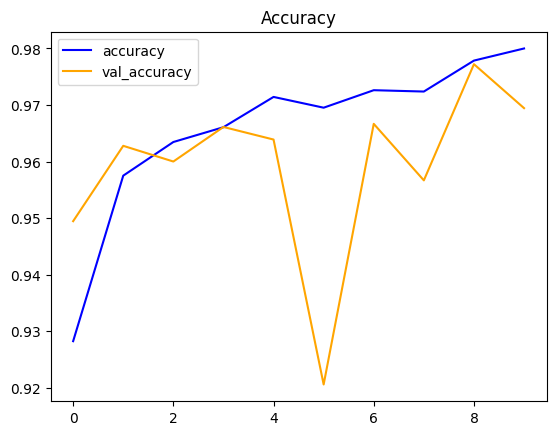

In [21]:
plt.plot(history.history['accuracy'],color='blue',label='accuracy')
plt.plot(history.history['val_accuracy'],color='orange',label='val_accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

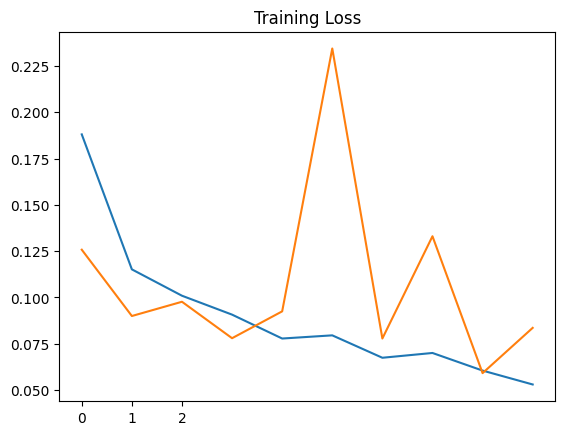

In [22]:
x=list(range(0,3))
plt.plot(model_hist['loss'])
plt.plot(model_hist['val_loss'])
plt.xticks(x)
plt.title("Training Loss")
plt.show()

In [23]:
y_pred_model=model.predict(x_test)
y_pred_model=np.argmax(y_pred_model,axis=1)
print(classification_report(y_pred_model,y_test))

57/57 [==============================] - 85s 1s/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       638
           1       0.99      0.91      0.95       659
           2       0.89      0.99      0.93       503

    accuracy                           0.96      1800
   macro avg       0.96      0.96      0.96      1800
weighted avg       0.96      0.96      0.96      1800



In [24]:
accuracy_score(y_test,y_pred_model)

0.9616666666666667

In [25]:
model.save("model1.h5")

c:\Users\abi\Desktop\abijith\DeepLearning\DL\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
